# Simulating a Double Pendulum with Lagrangian Mechanics

The double pendulum is the classical example of a chaotic system, one that is sensitive to initial conditions. In this notebook, we use `sympy`, `numpy` and `scipy` to develop and simulate a double pendulum model. The double pendulum is a complex system with many dynamic forces that act on it. So, we will be using something called Lagrangian mechanics to find the equations of motion of the double pendulum. We will also ignore atmospheric drag for this system.

![Double Pendulum](resources/double-pendulum.svg)

We first determine the Lagrangian. The Lagrangian in this context is defined by difference between Kinetic energy ($T$) and Potential energy ($V$). Loosely, the Lagrangian defines the state of the energy in the system (either completely positive for all kinetic energy or completely negative for all potential energy)

$$
L = T - V
$$

Lagrangian mechanics deals with the principle of least action, or the sum of the Lagrangian quantity as a system moves across a partiular path in it's coordinate system. I won't go through the derivation, but [this video by The Science Asylum](https://www.youtube.com/watch?v=MIBfKJHMWHU) describes Lagrangian mechanics in more detail. Skipping to the result of this formulation, we get this equation.

$$
\frac{\partial L}{\partial q_i} - \frac{d}{dt} \left( \frac{\partial L}{\partial \dot{q_i}} \right) = 0
$$

Where $q_i$ are the generalized coordinates of the system, which in our case are $\theta_1$ and $\theta_2$

We plug in our particular Lagrangian formula into the Euler-Lagrange equation and solve for the free variables in order to get the equations of motion

What we'll do first is construct the lagrangian formula based on the $x_1$, $y_1$, $x_2$, and $y_2$ coordinates respectively, defined in the diagram above. And then substitute these coordinates with their representation in $\theta$ coordinates.

Since the equations can get unruly, we will get some help from the `sympy` library to construct and solve our equations

In [1]:
import scipy.integrate as spi
import sympy as sp
import sympy.physics.mechanics as spm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from IPython.display import HTML
import warnings
sp.init_printing()
spm.init_vprinting()
warnings.filterwarnings('ignore', category=DeprecationWarning)

def equation(symbol, output):
    """
    Helper function for displaying equations
    """
    return display(sp.Eq(sp.S(symbol), output))

## Deriving the Equations of Motion

First we derive our equations using our $x$ and $y$ coordinates.

In [2]:
g, m1, L1, m2, L2 = sp.symbols('g m_1 L_1 m_2 L_2')              # Constants
t = sp.symbols('t')                                              # Time of system
x1, x2, y1, y2 = spm.dynamicsymbols('x_1 x_2 y_1 y_2')           # X,Y Coordinates
x1d, x2d, y1d, y2d = tuple( s.diff() for s in (x1, x2, y1, y2) ) # X,Y Derivatives

Our potential energy formula is related to the height $h$ of each mass off the ground.

$$
V = gm_1 h_1 + gm_2 h_2
$$

$h_1$ can be calculated from $y_1$, according to the graphic. $y_1$ is measured from the top down, with the minimum being $0$ and the maximum being $L_1$. So, $h_1$ can be defined as $L_1 - y_1$.

We might do something similar for $h_2$. However, in this case, the height of the second mass is also dependent on the height of the first, since they're both connected. So, we'll need to sum both contributions for our $h_2$ equation, giving $L_1 - y_1 + L_2 - y_2$. Our final potential energy equation becomes:

$$
V = g m_1 (L_1 - y_1) + g m_2 (L_1 - y_1 + L_2 - y_2)
$$

We can rearrange this to make things better for us (and `sympy`), by rearranging the equation in terms of $L_1 - y_1$ and $L_2 - y_2$

$$
V = g (m_1 + m_2) (L_1 - y_1) + g m_2 (L_2 - y_2)
$$

We can read this as the first height adds to the potential energy of both masses in the system, since it's lifting both masses by the same height.

In [3]:
# Potential Energy Formula
V = (m1 + m2)*g*(L1 - y1) + m2*g*(L2 - y2)
equation('V', V)

Next our kinetic energy formula. The kinetic energy is proportional to the square of the magnitude of velocity $v$.

$$
T = \frac{ m ||v||^2 }{ 2 }
$$

The quantity $||v||^2$ can be broken down into a sum of squares of changes in it's coordinates (via the pythagorean theorem) 

$$
||\dot{r}||^2 = \dot{x}^2 + \dot{y}^2
$$

Our kinetic energy then becomes the sum of this formula applied to each mass. However, like with potential energy, special consideration has to be given to the second mass since it depends on the motion of the first mass. The only thing that needs to change is that the total velocity of the second mass has to be the sum of the $x_2, y_2$ coordinates and the $x_1, y_1$ coordinates.

In [4]:
# Kinetic Energy Formula
half = sp.Rational(1,2)
T = half*m1*(x1d**2 + y1d**2) + half*m2*((x1d + x2d)**2 + (y1d + y2d)**2)
equation('T', T)

Finally, putting both these equations into the Lagrangian formula gives us the following

In [5]:
# Lagrangian Formula
L = T - V
equation('L', L)

Next we substitute our coordinates with $\theta_1$ and $\theta_2$ using conversion formulas

In [6]:
th1, th2 = spm.dynamicsymbols('\\theta_1 \\theta_2') # Theta coordiates
th1d = th1.diff()
th2d = th2.diff()

# Substitution
Lth = L.subs({
    x1: L1*sp.cos(th1),
    x2: L2*sp.cos(th2),
    y1: L1*sp.sin(th1),
    y2: L2*sp.sin(th2)
})
equation('L', Lth)

                                                                             ⎛
                                                                             ⎜
                                                                          m₁⋅⎜
                                                                             ⎝
L = -g⋅m₂⋅(-L₂⋅sin(\theta₂) + L₂) - g⋅(m₁ + m₂)⋅(-L₁⋅sin(\theta₁) + L₁) + ────
                                                                              

                     2                        2⎞      ⎛                       
⎛∂                  ⎞    ⎛∂                  ⎞ ⎟      ⎜⎛∂                     
⎜──(L₁⋅sin(\theta₁))⎟  + ⎜──(L₁⋅cos(\theta₁))⎟ ⎟   m₂⋅⎜⎜──(L₁⋅sin(\theta₁)) + 
⎝∂t                 ⎠    ⎝∂t                 ⎠ ⎠      ⎝⎝∂t                    
──────────────────────────────────────────────── + ───────────────────────────
                     2                                                        

                    2                             

We can actually use trig identities to simplify a whole lot of this.

In [7]:
Lth = Lth.simplify().trigsimp()
equation('L', Lth)

Now we construct our differential equations

In [8]:
Eq1 = sp.Eq(Lth.diff(th1.diff()).diff(t), Lth.diff(th1)).simplify()
Eq2 = sp.Eq(Lth.diff(th2.diff()).diff(t), Lth.diff(th2)).simplify()
display(Eq1)
display(Eq2)

And finally, solve for $\ddot{\theta}$

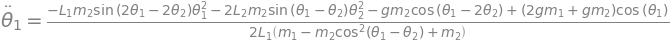

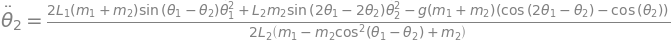

In [9]:
# Get solution
th1dd = th1.diff(t,t)
th2dd = th2.diff(t,t)
Thdd = sp.solve([Eq1, Eq2], [th1dd, th2dd], dict=True)[0]
Th1dd = Thdd[th1dd]
Th2dd = Thdd[th2dd]

# Clean up equations
Th1dd = Th1dd.simplify()
numer, denom = Th1dd.as_numer_denom()
numer = numer.collect(sp.cos(th1))
Th1dd = numer / denom
Th2dd = Th2dd.simplify()
numer, denom = Th2dd.as_numer_denom()
numer = numer.collect([
    2*L1*th1.diff()**2*sp.sin(th1 - th2),
    g*sp.cos(th2),
    -g*sp.cos(2*th1 - th2)
])
numer = numer.collect([
    g*(m1 + m2)
])
numer = numer.simplify()
Th2dd = numer / denom

# Display them
display(sp.Eq(th1dd, Th1dd))
display(sp.Eq(th2dd, Th2dd))

## Numerical Solutions

So finally, we come to our equation, and we'll build a python class for our differential equation and run numerical solutions. The double pendulum in particular is used to show how slight changes in initial conditions can result in dramatically different paths the system can take. So, we have multiple double pendulums, all with slightly different initial conditions, which result in dramatically different evolutions of the system

In [10]:
# Apply universal gravitational constant
gValue = 9.81
Thdd[th1dd] = Thdd[th1dd].subs(g, gValue)
Thdd[th2dd] = Thdd[th2dd].subs(g, gValue)

class DoublePendulum:
    """
    A double pendulum system which acts as a differential function.
    """
    def __init__(self, m1V, L1V, m2V, L2V):
        """
        Initialize with parameters
        
        :param m1V: mass of m1
        :param L1V: length of pendulum 1
        :param m2V: mass of m2
        :param L2V: length of pendulum 2
        """
        self.m1 = m1V
        self.m2 = m2V
        self.L1 = L1V
        self.L2 = L2V
        self._subdict = { m1: self.m1, L1: self.L1, m2: self.m2, L2: self.L2 }
        self._Th1ddS = Thdd[th1dd].subs(self._subdict)
        self._Th1ddF = sp.lambdify([th1, th2, th1d, th2d], self._Th1ddS)
        self._Th2ddS = Thdd[th2dd].subs(self._subdict)
        self._Th2ddF = sp.lambdify([th1, th2, th1d, th2d], self._Th2ddS)
        
    def __call__(self, t, Th):
        """
        Pendulum differential function
        
        :param t: current time of the system
        :param Th: current state of the system
        """
        th1, th2, om1, om2 = Th
        return np.array([
            om1,
            om2,
            self._Th1ddF(th1, th2, om1, om2),
            self._Th2ddF(th1, th2, om1, om2)
        ])

# Create pendulum instance
pendulum = DoublePendulum(m1V=2, L1V=4, m2V=2, L2V=4)
L1_ = pendulum.L1
L2_ = pendulum.L2

# Time parameters
T = [0, 100]
dt_max = 0.05

# Slightly different initial conditions
ThIs = [
    [ 0, 0.0001, 0, 0 ],
    [ 0, 0.0002, 0, 0 ],
    [ 0.0001, 0.0003, 0, 0 ],
    [ 0.0002, 0.0003, 0, 0 ]
]

# Generate numerical solutions
Ths = [ spi.solve_ivp(pendulum, T, ThI, max_step=dt_max).y for ThI in ThIs ]

## Simulating

Since this system has 4 free variables that all depend on each other, it can be hard to visualize using a phase plot. Instead of analyzing the solution that way, we can actually just simulate the evolution the system using Matplotlib's animation framework.

In [11]:
# Animation parameters
size = 6
vshift = 2
dims = 12, 9
trail_length = 20
frame_interval = 20

# Convert solution to X,Y components
Lv = np.array([
    [L1_, 0,  0,  0],
    [0,  0,  L1_, 0],
    [L1_, L2_, 0,  0],
    [0,  0,  L1_, L2_]
])
CosSins = [
    np.concatenate((np.cos(Th[0:2,:]), 1 - np.sin(Th[0:2,:])))
    for Th in Ths
]
XYs = [ np.dot(Lv, CosSin) for CosSin in CosSins ]

# Create figure
L = L1_ + L2_
ylim = L - 2*size + vshift, L + vshift
xsize = size * dims[0] / dims[1]
xlim = -xsize, xsize
fig = plt.figure(figsize=dims, frameon=False)
axes = plt.axes(xlim=xlim, ylim=ylim)
plt.xticks([])
plt.yticks([])

# Artists
lines = [ axes.plot([], [], lw=1, ls='--')[0] for XY in XYs ]
pendulums = [ axes.plot([], [], lw=3, c=line.get_color(), marker='o')[0] for line in lines ]

def animate(i):
    """
    Determine each frame
    """
    j = max(i - trail_length, 0)
    for line, pendulum, XY in zip(lines, pendulums, XYs):
        line.set_data(XY[2,j:i], XY[3,j:i])
        pendulum.set_data(
            [0, XY[0,i], XY[2,i]], 
            [L2_ + L1_, L2_ + XY[1,i], XY[3,i]])
    return lines + pendulums

# Generate and render animation
animation = anim.FuncAnimation(
    fig, animate, frames=min(XY.shape[1] for XY in XYs), 
    interval=frame_interval, blit=True)
plt.close(fig)
HTML(animation.to_html5_video())